In [28]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

from scipy.stats import norm

from tqdm import tqdm

from signal_handling.processing import get_evm_outlier_indices, delete_outliners
# from nft_handling.nft_analyse import get_energy_discrete, get_energy_continuous
from signal_handling.ssfm import get_energy

from hpcom.metrics import get_ber_by_points
from hpcom.modulation import get_modulation_type_from_order, get_nearest_constellation_points_new, get_constellation

In [3]:
import sys
print(sys.executable)

/home/esf0/anaconda3/envs/tf/bin/python


In [64]:
# data_dir = '/home/esf0/research/nft_wdm_proc/'
data_dir = '/media/esf0/Seagate/research/nft_wdm_proc/'
run_name = 'run_6_n'

df_meta = pd.DataFrame()
df = pd.DataFrame()

# for n_index in [2, 3]:
for n_index in [2]:

    file_name = 'results_processing_process_signal_' + run_name + str(n_index) + '_'
    meta_file_name= 'results_meta_process_signal_' + run_name + str(n_index) + '.pkl'

    try:
        df_read_meta = pd.read_pickle(data_dir + meta_file_name)
        df_meta = pd.concat([df_meta, df_read_meta], ignore_index=True)
    except:
        print('File not found: ', meta_file_name)

    for index in range(0, 12):
        try:
            df_read = pd.read_pickle(data_dir + file_name + str(index) + '.pkl')
            df = pd.concat([df, df_read], ignore_index=True)
        except:
            print('File not found: ', file_name + str(index) + '.pkl')
            continue



In [65]:
df_meta.iloc[0]

signal_x              [(-0.009105773442466115+0.010116926077922665j)...
wdm_info              {'ft_filter_values_x': [(tf.Tensor((2.00835348...
signal_prop           [(0.007070496092201169+0.01354224188288607j), ...
signal_cdc            [(0.005119417964625981-0.011042202735019678j),...
points_x_cdc          [(0.006777509603881817-0.012588372601374513j),...
points_x_orig         [(-0.011220184543019634+0.011220184543019634j)...
process_parameters    {'z_prop': 0, 'n_symb_proc': 32, 'n_symb_side'...
wdm                   {'n_channels': 1, 'channel_spacing': 750000000...
channel               {'n_spans': 12, 'z_span': 80, 'alpha_db': 0.0,...
points                [(0.011220184543019634-0.0336605536290589j), (...
points_nft            [(0.010432696150102868-0.03340749740774383j), ...
evm                   [0.000771168893451462, 0.0008066749737481354, ...
return_values         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: 0, dtype: object

In [66]:
n_symb_proc = df_meta.process_parameters[0]['n_symb_proc']
p_ave_dbm = df_meta.wdm[0]['p_ave_dbm']
print('P_ave_dbm: ', p_ave_dbm)
print(df_meta.wdm[0])
print(df_meta.channel[0])

points = df_meta.points[0]
points_nft = df_meta.points_nft[0]
evms = df_meta.evm.values[0]

P_ave_dbm:  1
{'n_channels': 1, 'channel_spacing': 75000000000.0, 'n_polarisations': 1, 'p_ave_dbm': 1, 'n_symbols': 65536, 'm_order': 16, 'roll_off': 0.1, 'upsampling': 4, 'downsampling_rate': 1, 'symb_freq': 34000000000.0, 'sample_freq': 136000000000, 'np_filter': 4096, 'p_ave': 0.0012589254117941673, 'modulation_type': '16qam', 'n_bits_symbol': 4, 'seed': 'time', 'scale_coef': 89.12509381337456}
{'n_spans': 12, 'z_span': 80, 'alpha_db': 0.0, 'alpha': 0.0, 'gamma': 1.2, 'noise_figure_db': -200, 'noise_figure': 1e-20, 'gain': 1.0, 'dispersion_parameter': 16.8, 'beta2': -2.1412706043583603e-23, 'beta3': 0, 'h_planck': 6.62607015e-34, 'fc': 193414489032258.06, 'dz': 1.0, 'nz': 80, 'noise_density': 0.0, 'seed': 'fixed'}


In [2]:
def get_energy_discrete(eigenvalues):
    return 4 * np.sum(np.imag(eigenvalues))


def trapezoidal_integral(a, step=1.0):
    return step * (np.sum(a) - 0.5 * (a[0] + a[-1]))


def get_energy_continuous(a_xi, xi):
    return -1. / np.pi * trapezoidal_integral(np.log(np.power(np.absolute(a_xi), 2)), step=(xi[1] - xi[0]))
    # return -1. / np.pi * trapezoidal_integral(np.power(np.log(np.absolute(a_xi)), 2), step=(xi[1] - xi[0]))

#
def get_energy_continuous_b(b_xi, xi):
    return -1. / np.pi * trapezoidal_integral(np.log(1. + np.power(np.absolute(b_xi), 2)), step=(xi[1] - xi[0]))


In [315]:
median = np.median(evms[~np.isnan(evms)])
median_absolute_deviation = np.median(np.abs(evms[~np.isnan(evms)] - median))
modified_z_scores = 0.6745 * (evms - median) / median_absolute_deviation

print(median, median_absolute_deviation, modified_z_scores)

0.0010590750144605751 0.0001380939635312944 [-1.40623582 -1.23281151 -1.13911407 ...  0.40730399 -0.23430013
  1.44537806]


In [16]:
def outliers_modified_z_score(evms, threshold=3.5):

    median = np.median(evms[~np.isnan(evms)])
    median_absolute_deviation = np.median(np.abs(evms[~np.isnan(evms)] - median))
    modified_z_scores = 0.6745 * (evms - median) / median_absolute_deviation
    outlier_indices = np.where((np.abs(modified_z_scores) > threshold) | (np.isnan(evms)))
    ok_indices = np.where((np.abs(modified_z_scores) <= threshold) & (~np.isnan(evms)))
    return outlier_indices, ok_indices


def delete_evm_nan(points, evms, n_symb_proc):

    points_shaped = points.reshape((-1, n_symb_proc))  # slice with initial n_symb_proc
    outlier_indices = np.where(np.isnan(evms))
    ok_indices = np.where(~np.isnan(evms))
    return points_shaped[ok_indices].reshape(-1)  # reshape back


def get_evm_outlier_indices(evms, n_std_dev=2.5):

    mean = np.mean(evms)
    std_dev = np.std(evms)

    # Any point more than 3 standard deviations away from the mean will be considered an outlier
    # outlier_indices = np.where(np.abs(evms - mean) > 3*std_dev)  # both sides
    outlier_indices = np.where((evms - mean) > n_std_dev*std_dev)  # only right side (significantly bigger)
    ok_indices = np.where((evms - mean) <= n_std_dev*std_dev)  # only right side (significantly bigger)

    return outlier_indices, ok_indices


def delete_outliners(points, evms, n_symb_proc, threshold=3.5):

    points_shaped = points.reshape((-1, n_symb_proc))  # slice with initial n_symb_proc
    outlier_indices, ok_indices = outliers_modified_z_score(evms, threshold=threshold)  # find indices to left
    return points_shaped[ok_indices].reshape(-1)  # reshape back

In [76]:
points_nft_good = delete_outliners(points_nft, evms, n_symb_proc, threshold=3.5)
print(np.shape(points_nft_good), np.shape(points_nft))

(31168,) (32768,)


In [77]:
np.mean(points_nft_good)

(-0.0002424525461298515-0.00012322112933906788j)

In [250]:
df_meta.wdm[0]['scale_coef']

141.25375446227545

In [6]:
def form_info(df, df_meta, experiment, add_discrete=True, all_points=False):

    n_symb_proc = df_meta.process_parameters[0]['n_symb_proc']
    p_ave_dbm = df_meta.wdm[0]['p_ave_dbm']
    print('P_ave_dbm: ', p_ave_dbm)
    # print(df_meta.wdm[0])
    # print(df_meta.channel[0])

    points = df_meta.points[0]
    points_nft = df_meta.points_nft[0]
    evms = df_meta.evm.values[0]

    if all_points:
        # outlier_indices = [np.array([])]
        points_nft_good = delete_evm_nan(points_nft, evms, n_symb_proc)
        points_good = delete_evm_nan(points, evms, n_symb_proc)
    else:
        points_good = delete_outliners(points, evms, n_symb_proc, threshold=3.5)
        points_nft_good = delete_outliners(points_nft, evms, n_symb_proc, threshold=3.5)
        outlier_indices, ok_indices = outliers_modified_z_score(evms, threshold=3.5)

    

    energy_signal = []
    energy_disc = []
    n_disc = []
    max_imag_disc = []

    xi_d_all = []

    xi = df.xi[0]
    t = df.t_for_nft[0]

    for ind in tqdm(range(len(df))):
        if ind in outlier_indices[0]:
            continue

        q = df.q_windowed_cdc[ind]
        # b = df.b[ind]
        # r = df.r[ind]
        # a = b / r
        xi_d = df.xi_d[ind]

        if add_discrete:
            xi_d_all.append(xi_d)

        energy_signal.append(get_energy(q, t[-1] - t[0]))
        energy_disc.append(get_energy_discrete(xi_d))
        n_disc.append(len(xi_d))
        # print(np.shape(xi_d))
        max_imag_disc.append(np.max(np.imag(xi_d)))

    print('Len:', len(points_good), len(points_nft_good))


    scale = df_meta.wdm[0]['scale_coef']
    # print(np.shape(points), np.shape(points_nft_good), scale)

    modulation = get_modulation_type_from_order(df_meta.wdm[0]['m_order'])
    points_nft_found = get_nearest_constellation_points_new(points_nft_good * scale, get_constellation(modulation))
    ber = get_ber_by_points(points_good * scale, points_nft_found, modulation)

    result = {'p_ave_dbm': [p_ave_dbm],
              'experiment': [experiment],
              'ber': [ber],
              'energy_signal': [energy_signal],
              'energy_disc': [energy_disc],
              'n_disc': [n_disc],
              'max_imag_disc': [max_imag_disc],
              'points_good': [points_good],
              'points_nft_good': [points_nft_good]}

    if add_discrete:
        result['xi_d_all'] = [xi_d_all]

    return result

In [ ]:
type = '_type_2'
# type = ''
# experiments = ['n1', 'n2', 'n3']  # list of experiment names
experiments = ['n2', 'n3']  # list of experiment names
# experiments = ['n2']  # list of experiment names
df_res = pd.DataFrame()

for experiment in experiments:
    # for run_num in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    for run_num in range(1, 18):

        # data_dir = '/home/esf0/research/nft_wdm_proc/'
        data_dir = '/media/esf0/Seagate/research/nft_wdm_proc/'
        file_name = 'results_processing_process_signal' + type + '_run_' + str(run_num) + '_' + experiment + '_'
        meta_file_name= 'results_meta_process_signal' + type + '_run_' + str(run_num) + '_' + experiment + '.pkl'

        try:
            df_meta = pd.read_pickle(data_dir + meta_file_name)
            df = pd.DataFrame()
        except:
            print('No file: ', meta_file_name)
            continue

        for index in range(0, 12):
            try:
                df_read = pd.read_pickle(data_dir + file_name + str(index) + '.pkl')
                df = pd.concat([df, df_read], ignore_index=True)
            except:
                print('No file: ', file_name + str(index) + '.pkl')

        df_res = pd.concat([df_res, pd.DataFrame(form_info(df, df_meta, experiment, add_discrete=True))], ignore_index=True)

In [20]:
df_res[df_res.p_ave_dbm == -2]


,p_ave_dbm,experiment,ber,energy_signal,energy_disc,n_disc,max_imag_disc,points_good,points_nft_good,xi_d_all
8,-2,n2,"(0.0, 0)","[19.201632756046568, 19.168834099862092, 19.06...","[18.151035217867673, 18.132829684601344, 17.90...","[320, 321, 322, 323, 318, 316, 312, 304, 306, ...","[0.07719925211168306, 0.07719927958783501, 0.0...","[(0.02382984704172844+0.007943282347242814j), ...","[(0.02416010274081442+0.007609430434505043j), ...","[[(0.032465034038305564+0.07719925211168306j),..."
18,-2,n3,"(0.0, 0)","[19.14587756458675, 19.339046073234282, 19.425...","[18.106625296724914, 18.208155826092455, 18.35...","[316, 316, 324, 326, 321, 315, 313, 318, 316, ...","[0.05920449442075451, 0.059205935925293766, 0....","[(-0.02382984704172844-0.02382984704172844j), ...","[(-0.024472351410472253-0.02302302671805241j),...","[[(-0.6006285165701309+0.05920449442075451j), ..."


In [155]:
a = []
a += df_res[(df_res.experiment == 'n2') & (df_res.p_ave_dbm == -2)].xi_d_all.values[0]
a += df_res[(df_res.experiment == 'n3') & (df_res.p_ave_dbm == -2)].xi_d_all.values[0]

In [119]:
energy_percent = []
n_disc = []
ber = []
p_ave_list = np.array([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6])
xi_d = []
add_discrete = True

for p_ave_dbm_k in p_ave_list:

    d_cur = None
    for d in results:
        if d['p_ave_dbm'] == p_ave_dbm_k:
            d_cur = d
            break

    energy_percent.append(np.mean(np.array(d_cur['energy_disc']) / np.array(d_cur['energy_signal'])))
    ber.append(d_cur['ber'][0])
    n_disc.append(np.mean(d_cur['n_disc']))
    if add_discrete:
        xi_d.append(d_cur['xi_d_all'])

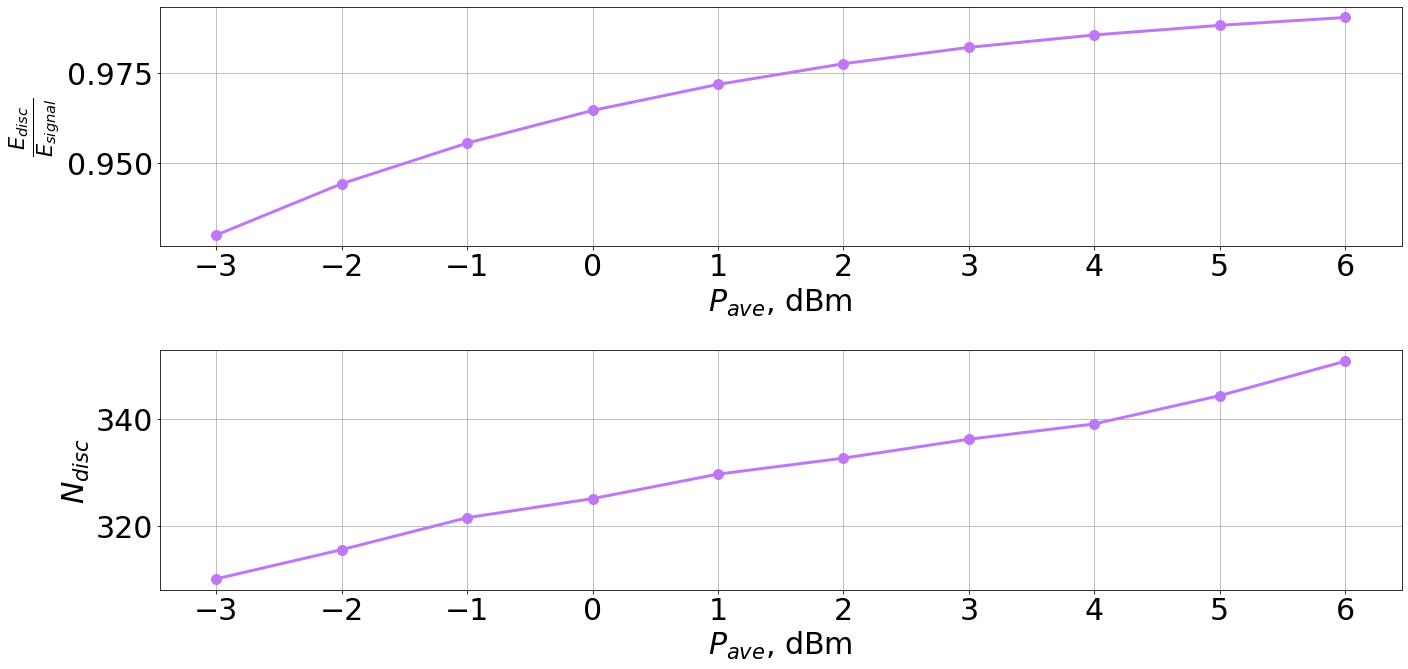

In [110]:
matplotlib.rcParams.update({'font.size': 30})
color = ['xkcd:light purple', 'xkcd:cyan', 'xkcd:lime green']
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].plot(p_ave_list, energy_percent, color[0], linewidth=3, marker='o', markersize=10)
axs[0].grid()
axs[0].set_xticks(p_ave_list)
axs[0].set_xlabel(r'$P_{ave}$, dBm')
axs[0].set_ylabel(r'$\frac{E_{disc}}{E_{signal}}$')

axs[1].plot(p_ave_list, n_disc, color[0], linewidth=3, marker='o', markersize=10)
axs[1].grid()
axs[1].set_xticks(p_ave_list)
axs[1].set_xlabel(r'$P_{ave}$, dBm')
axs[1].set_ylabel(r'$N_{disc}$')

plt.tight_layout()
plt.show()

fig.savefig('images/' + 'discrete_spectrum_vs_power.pdf', format='pdf', bbox_inches='tight')
fig.savefig('images/' + 'discrete_spectrum_vs_power.png', format='png', bbox_inches='tight')

# axs[1].plot(p_ave_list, ber, color[0], linewidth=1, marker='o', markersize=10)
# axs[1].set_yscale('log')
# axs[1].grid()

In [188]:
p_ave_dbm_cur = 5
result = None
for d in results:
    if d['p_ave_dbm'] == p_ave_dbm_cur:
        result = d
        break

In [183]:
df_res[(df_res.experiment == experiment) & (df_res.p_ave_dbm == p_ave_dbm_cur)]['max_imag_disc'].values[0]

[0.347083030540508,
 0.3470830443755875,
 0.34708378043599575,
 0.34708299803338605,
 0.34708102542503133,
 0.34686708205253036,
 0.32000446987319053,
 0.3199974458212695,
 0.32001173318018894,
 0.3197673624762486,
 0.3193354687092832,
 0.3152994153535629,
 0.3153625390010064,
 0.31530764592789756,
 0.3153078999559662,
 0.315307988022978,
 0.3153081134717234,
 0.3153080618146231,
 0.3153073158042267,
 0.315327585011456,
 0.3152587335143086,
 0.3151851777739544,
 0.31598730447483214,
 0.31484685795015827,
 0.3325612844506055,
 0.3435048767439363,
 0.3675057740074715,
 0.37182096345653476,
 0.371632438696092,
 0.3967979842922914,
 0.4577980005270405,
 0.32611855741673185,
 0.32605756907923394,
 0.32612718127211404,
 0.3246978183872635,
 0.32012495639563104,
 0.29707057094247774,
 0.3186298095872901,
 0.26645965636321833,
 0.3505407100956719,
 0.3526654494676263,
 0.35265035621234175,
 0.35264379726805356,
 0.35264267891477247,
 0.35264319721394183,
 0.3526410451193072,
 0.352720183194691

In [9]:
def get_me_that(df_res, name_of_that, experiments, p_ave_dbm_cur):
    
    that = []
    for experiment in experiments:
        print('experiment: ', experiment)
        try:
            that += df_res[(df_res.experiment == experiment) & (df_res.p_ave_dbm == p_ave_dbm_cur)][name_of_that].values[0]
            print(len(that), 'done')
        except Exception as e:
            print('Ups', e)
            
    return that

In [15]:
print(df_res[['ber', 'p_ave_dbm', 'experiment']])

                            ber  p_ave_dbm experiment
0                      (0.0, 0)          3         n2
1                      (0.0, 0)          4         n2
2                      (0.0, 0)          5         n2
3   (2.1029609690444146e-05, 1)          6         n2
4                      (0.0, 0)          2         n2
5                      (0.0, 0)          1         n2
6                      (0.0, 0)          0         n2
7                      (0.0, 0)         -1         n2
8                      (0.0, 0)         -2         n2
9                      (0.0, 0)         -3         n2
10                     (0.0, 0)         -4         n2
11                     (0.0, 0)         -5         n2
12                     (0.0, 0)         -6         n2
13                     (0.0, 0)         -7         n2
14                     (0.0, 0)         -8         n2
15                     (0.0, 0)         -9         n2
16                     (0.0, 0)        -10         n2
17                     (0.0,

In [10]:
p_ave_dbm_cur = 6
n_disc_plot = []

# for experiment in experiments:
#     print('experiment: ', experiment)
#     try:
#         n_disc_plot += df_res[(df_res.experiment == experiment) & (df_res.p_ave_dbm == p_ave_dbm_cur)].n_disc.values[0]
#         print(len(n_disc_plot), 'done')
#     except Exception as e:
#         print('Ups', e)
# 

n_disc_plot = get_me_that(df_res, 'n_disc', experiments, p_ave_dbm_cur)
print(len(n_disc_plot))

max_imag_disc_plot = get_me_that(df_res, 'max_imag_disc', experiments, p_ave_dbm_cur)

experiment:  n2
743 done
experiment:  n3
1496 done
1496
experiment:  n2
743 done
experiment:  n3
1496 done


In [18]:
p_ave_dbm_list = np.arange(-10, 7, 1)
e_disc = []
e_signal = []
e_percent = []
n_disc = []
for p_ave_dbm_cur in p_ave_dbm_list:
    e_disc_cur = np.mean(get_me_that(df_res, 'energy_disc', experiments, p_ave_dbm_cur))
    e_signal_cur = np.mean(get_me_that(df_res, 'energy_signal', experiments, p_ave_dbm_cur))
    
    e_disc.append(e_disc_cur)
    e_signal.append(e_signal_cur)
    e_percent.append(e_disc_cur / e_signal_cur)
    
    n_disc.append(np.mean(get_me_that(df_res, 'n_disc', experiments, p_ave_dbm_cur)))
    

experiment:  n2
1017 done
experiment:  n3
2027 done
experiment:  n2
1017 done
experiment:  n3
2027 done
experiment:  n2
1017 done
experiment:  n3
2027 done
experiment:  n2
1013 done
experiment:  n3
2016 done
experiment:  n2
1013 done
experiment:  n3
2016 done
experiment:  n2
1013 done
experiment:  n3
2016 done
experiment:  n2
994 done
experiment:  n3
1990 done
experiment:  n2
994 done
experiment:  n3
1990 done
experiment:  n2
994 done
experiment:  n3
1990 done
experiment:  n2
986 done
experiment:  n3
1973 done
experiment:  n2
986 done
experiment:  n3
1973 done
experiment:  n2
986 done
experiment:  n3
1973 done
experiment:  n2
987 done
experiment:  n3
1983 done
experiment:  n2
987 done
experiment:  n3
1983 done
experiment:  n2
987 done
experiment:  n3
1983 done
experiment:  n2
995 done
experiment:  n3
1978 done
experiment:  n2
995 done
experiment:  n3
1978 done
experiment:  n2
995 done
experiment:  n3
1978 done
experiment:  n2
971 done
experiment:  n3
1955 done
experiment:  n2
971 done


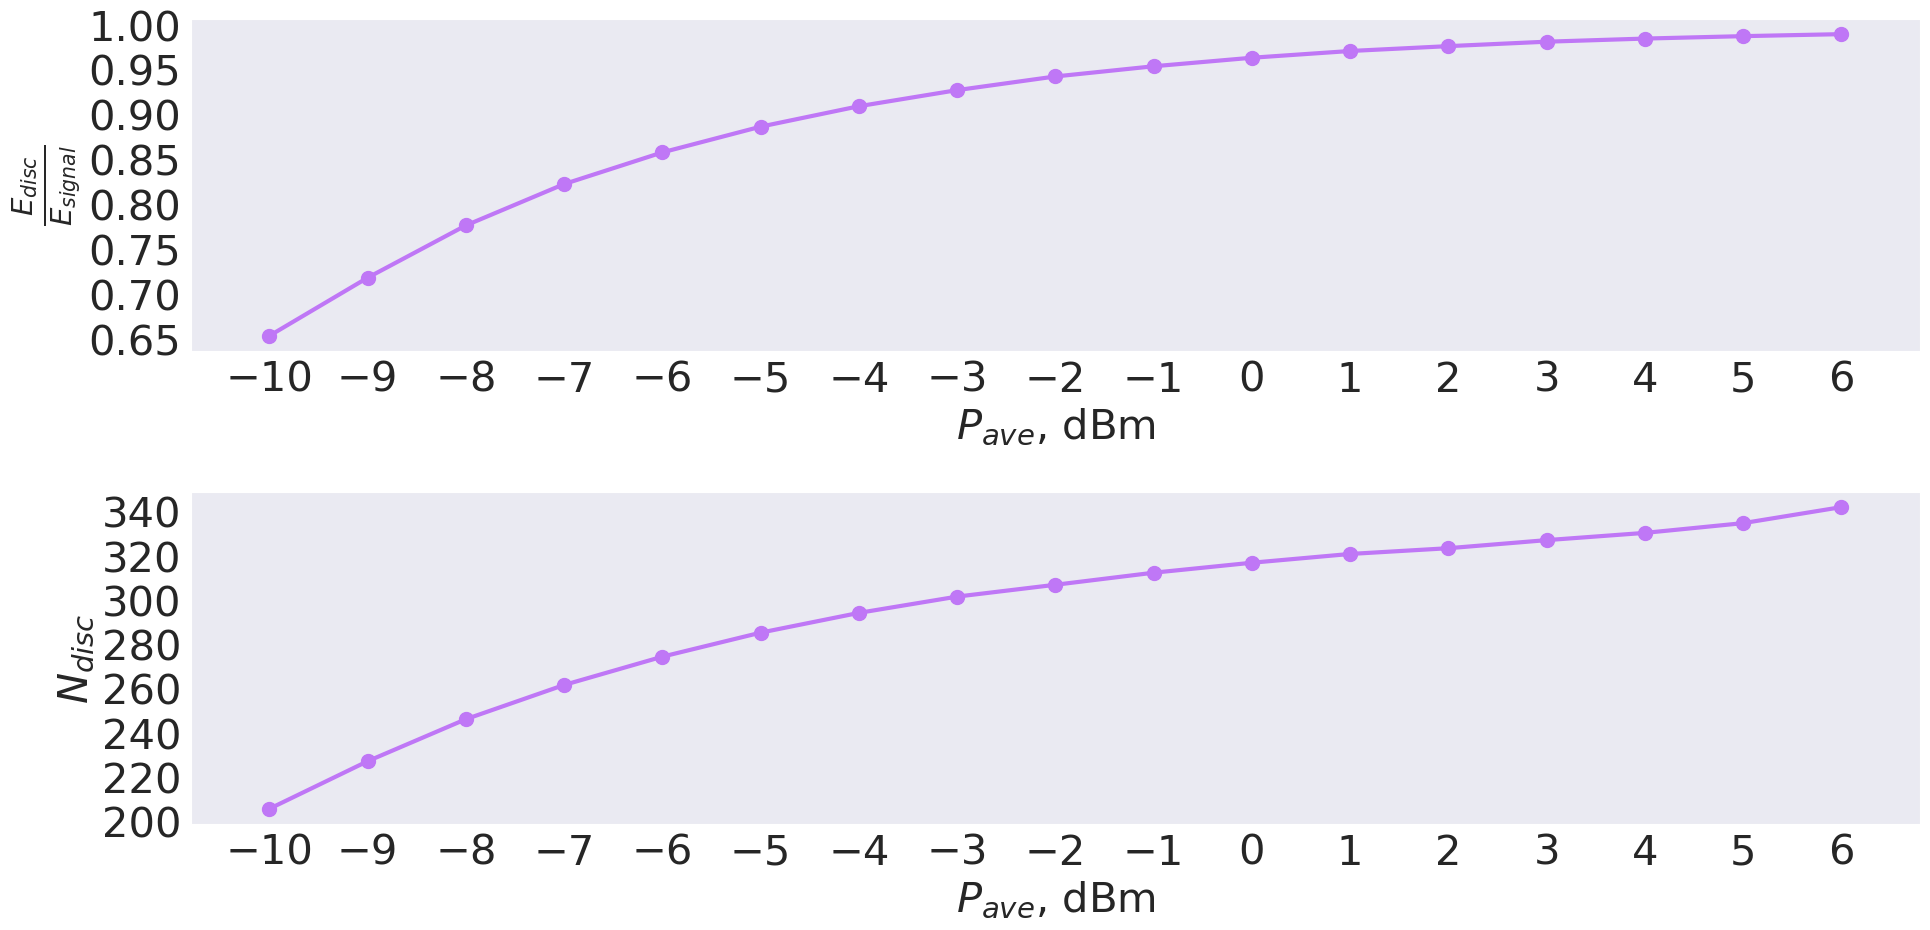

In [31]:
matplotlib.rcParams.update({'font.size': 30})
color = ['xkcd:light purple', 'xkcd:cyan', 'xkcd:lime green']
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].plot(p_ave_dbm_list, e_percent, color[0], linewidth=3, marker='o', markersize=10)
axs[0].set_xticks(p_ave_dbm_list)
axs[0].yaxis.set_major_locator(ticker.MaxNLocator(8))
axs[0].set_xlabel(r'$P_{ave}$, dBm')
axs[0].set_ylabel(r'$\frac{E_{disc}}{E_{signal}}$')
axs[0].grid()

axs[1].plot(p_ave_dbm_list, n_disc, color[0], linewidth=3, marker='o', markersize=10)
axs[1].set_xticks(p_ave_dbm_list)
# axs[1].set_yticks(np.arange(min(n_disc), max(n_disc) + 1, 15))
axs[1].yaxis.set_major_locator(ticker.MaxNLocator(10))

axs[1].set_xlabel(r'$P_{ave}$, dBm')
axs[1].set_ylabel(r'$N_{disc}$')
axs[1].grid()

plt.tight_layout()
plt.show()

fig.savefig('images/' + 'discrete_spectrum_vs_power' + type + '.pdf', format='pdf', bbox_inches='tight')
fig.savefig('images/' + 'discrete_spectrum_vs_power' + type + '.png', format='png', bbox_inches='tight')

# axs[1].plot(p_ave_list, ber, color[0], linewidth=1, marker='o', markersize=10)
# axs[1].set_yscale('log')
# axs[1].grid()

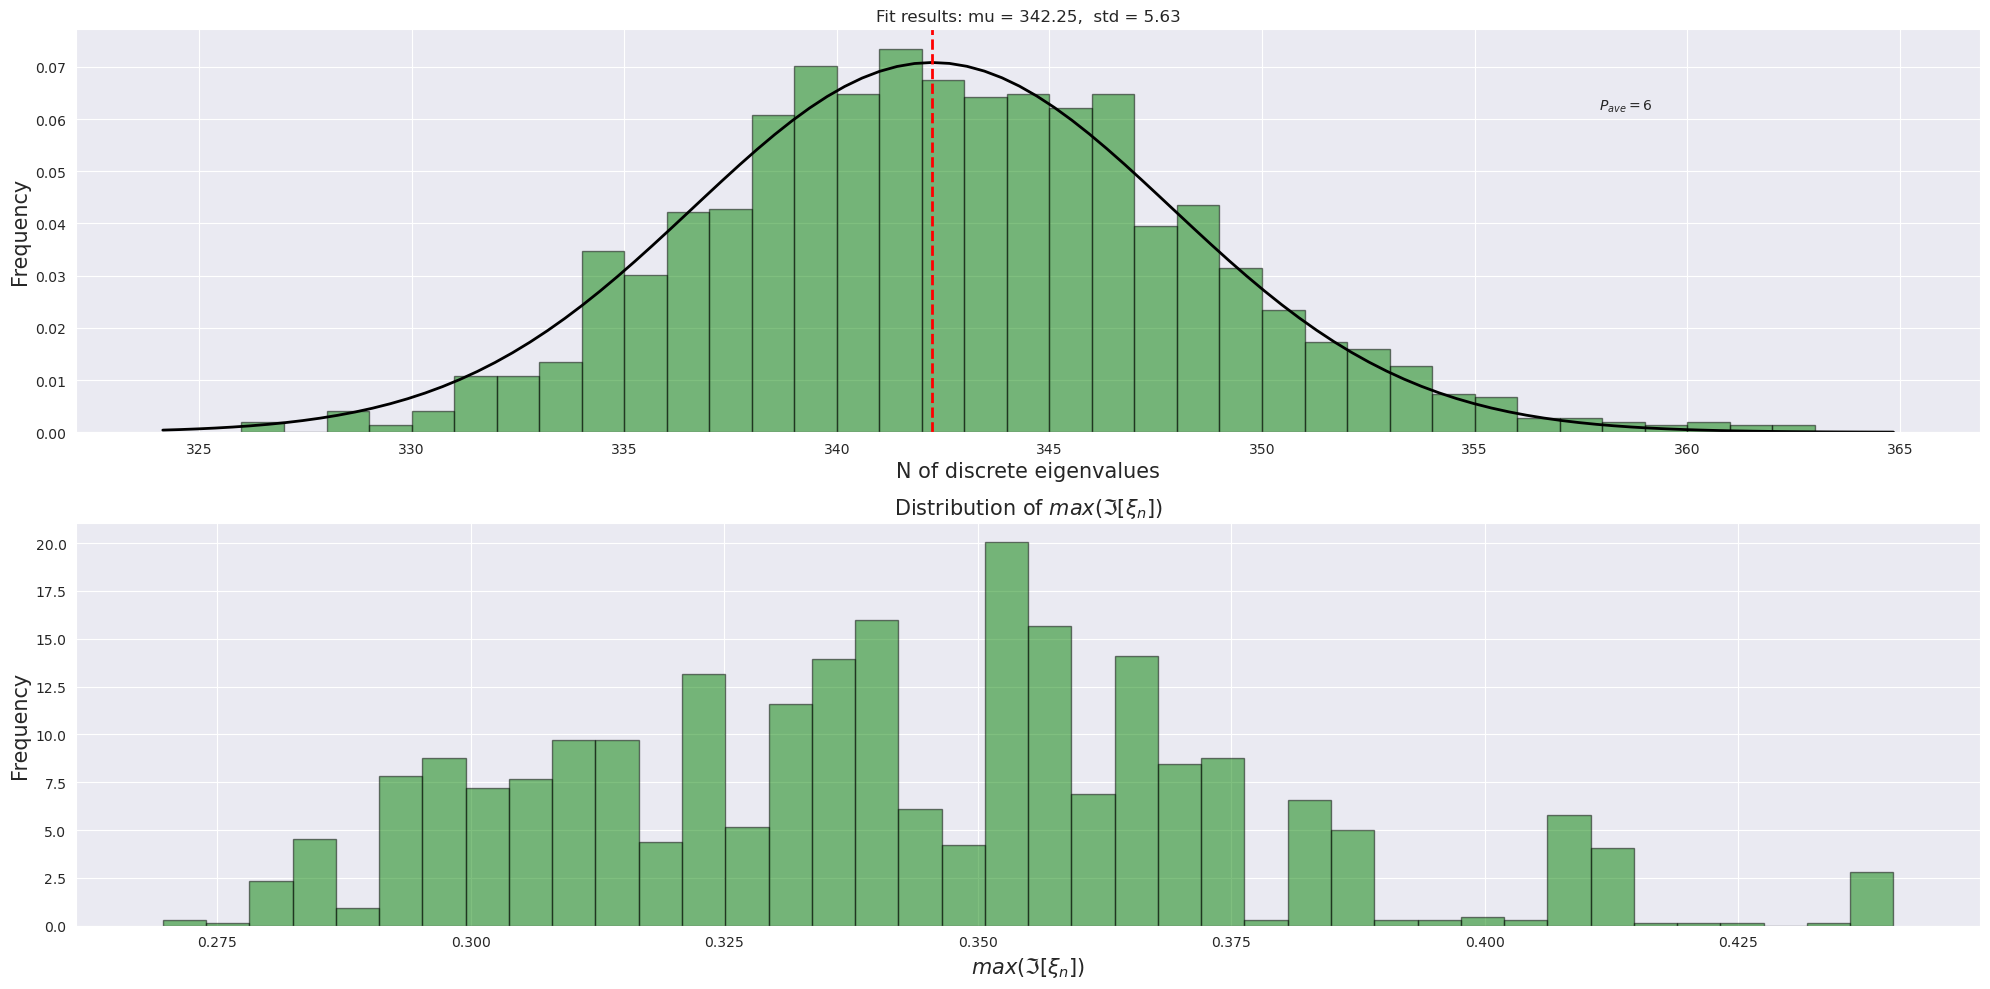

In [13]:
name_set = 'pavedbm_' + str(p_ave_dbm_cur) + type

fig, axs = plt.subplots(2, 1, figsize=(20, 10))

# Plot histogram for 'n_disc'
n_bins = (max(n_disc_plot) - min(n_disc_plot))
n, bins, patches = axs[0].hist(n_disc_plot, bins=n_bins, alpha=0.5, color='g', edgecolor='black', density=True)
axs[0].set_title('Distribution of n_disc', fontsize=15)
axs[0].set_xlabel('N of discrete eigenvalues', fontsize=15)
axs[0].set_ylabel('Frequency', fontsize=15)
axs[0].text(0.8, 0.8, r'$P_{ave} = %s$' % p_ave_dbm_cur, transform=axs[0].transAxes)

# Plot histogram for 'max_imag_disc'
axs[1].hist(max_imag_disc_plot, bins=40, alpha=0.5, color='g', edgecolor='black', density=True)
axs[1].set_title(r'Distribution of $max(\Im[\xi_n])$', fontsize=15)
axs[1].set_xlabel(r'$max(\Im[\xi_n])$', fontsize=15)
axs[1].set_ylabel('Frequency', fontsize=15)

# Fit a Gaussian (normal distribution) to the 'n_disc' histogram
mu, std = norm.fit(n_disc_plot)
xmin, xmax = axs[0].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axs[0].plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
axs[0].set_title(title)

# Draw a vertical line at the mean of 'n_disc'
axs[0].axvline(np.mean(np.array(n_disc_plot)), color='r', linestyle='dashed', linewidth=2)

plt.tight_layout()
plt.show()

fig.savefig('images/' + 'discrete_spectrum_' + name_set + '.pdf', format='pdf', bbox_inches='tight')
fig.savefig('images/' + 'discrete_spectrum_' + name_set + '.png', format='png', bbox_inches='tight')

numpy.ndarray

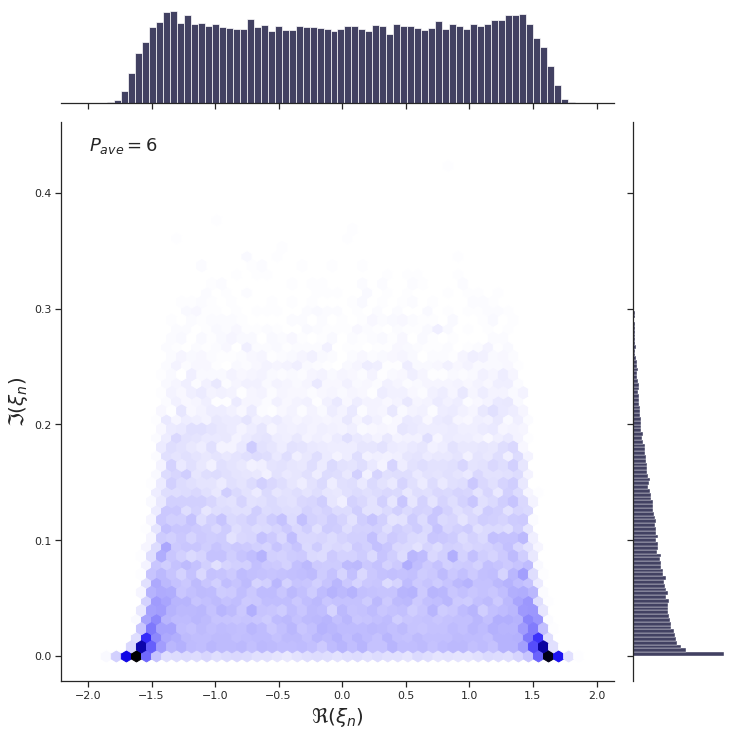

In [174]:
name_set = 'pavedbm_' + str(p_ave_dbm_cur)
xi_d_shaped = np.concatenate(result['xi_d_all'])

# Set font size for labels, title, and ticks
sns.set_context("notebook", rc={"axes.titlesize":20, "axes.labelsize":15, "xtick.labelsize":20, "ytick.labelsize":20})


sns.set_theme(style="ticks")
# sns.set_style("darkgrid")

jp = sns.jointplot(x=xi_d_shaped.real, y=xi_d_shaped.imag,
              height=10,
              kind="hex", color="#03012d")

# Add text: parameters are x position, y position, text, and optional font size
jp.ax_joint.text(0.05, 0.95, r'$P_{ave} = %s$' % p_ave_dbm_cur, fontsize=18, transform=jp.ax_joint.transAxes)


# Set the labels
jp.ax_joint.set_xlabel(r'$\Re(\xi_n)$', fontsize=20)
jp.ax_joint.set_ylabel(r'$\Im(\xi_n)$', fontsize=20)


# Save the figure
plt.savefig('images/' + 'discrete_spectrum_distribution_' + name_set + '.pdf', format='pdf', bbox_inches='tight')
plt.savefig('images/' + 'discrete_spectrum_distribution_' + name_set + '.png', format='png', bbox_inches='tight')


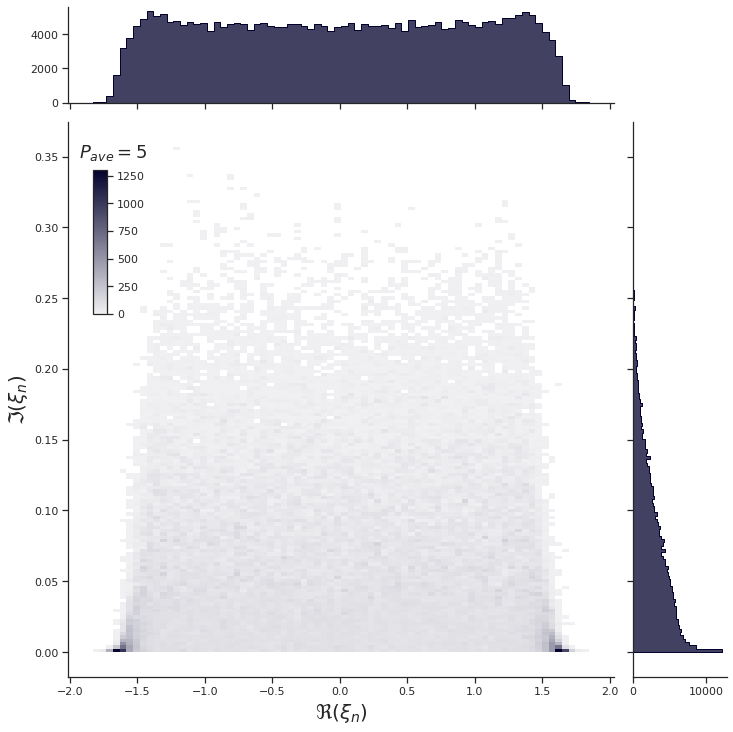

In [190]:

name_set = 'pavedbm_' + str(p_ave_dbm_cur)
xi_d_shaped = np.concatenate(result['xi_d_all'])

# Set font size for labels, title, and ticks
sns.set_context("notebook",
                rc={"axes.titlesize": 20, "axes.labelsize": 15, "xtick.labelsize": 20, "ytick.labelsize": 20})

sns.set_theme(style="ticks")
# sns.set_style("darkgrid")

g = sns.JointGrid(x=xi_d_shaped.real, y=xi_d_shaped.imag,
                  marginal_ticks=True,
                  height=10)

# Create an inset legend for the histogram colorbar
cax = g.figure.add_axes([.09, .55, .02, .2])

# Add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot,
    cmap="light:#03012d",
    cbar=True, cbar_ax=cax
)
g.plot_marginals(sns.histplot, element="step", color="#03012d")
#
# jp = sns.jointplot(x=xi_d_shaped.real, y=xi_d_shaped.imag,
#                    height=10,
#                    kind="hex", color="#03012d")
#
# Add text: parameters are x position, y position, text, and optional font size
g.ax_joint.text(0.07, 0.97, r'$P_{ave} = %s$' % p_ave_dbm_cur, fontsize=18, transform=jp.ax_joint.transAxes)
#
# Set the labels
g.ax_joint.set_xlabel(r'$\Re(\xi_n)$', fontsize=20)
g.ax_joint.set_ylabel(r'$\Im(\xi_n)$', fontsize=20)
#
# Save the figure
plt.savefig('images/' + 'discrete_spectrum_distribution2_' + name_set + '.pdf', format='pdf', bbox_inches='tight')
plt.savefig('images/' + 'discrete_spectrum_distribution2_' + name_set + '.png', format='png', bbox_inches='tight')

In [213]:
# r = b / a -> a = b / r
xi = df.xi[0]
print(np.shape(xi))

t = df.t_for_nft[0]

ind = 17
q = df.q_windowed_cdc[ind]
b = df.b[ind]
r = df.r[ind]
a = b / r
xi_d = df.xi_d[ind]

print(get_energy(q, t[-1] - t[0]))
print(get_energy_discrete(xi_d), get_energy_continuous(a, xi), get_energy_discrete(xi_d) + get_energy_continuous(a, xi))
print(get_energy_discrete(xi_d), get_energy_continuous_b(b, xi), get_energy_discrete(xi_d) + get_energy_continuous_b(b, xi))
# print(get_energy(np.log(np.power(np.absolute(a), 2)), xi[-1] - xi[0]) / np.pi)
print(np.sum(np.log(np.power(np.absolute(a), 2))) * (xi[1] - xi[0]) / np.pi)
print(get_energy_continuous(df.r[ind], xi))
# print(np.sum(np.power(np.log(np.absolute(a)), 2)) * (xi[1] - xi[0]) / np.pi)

(16384,)
121.96902952827537
120.73627403173238 -1.8390361505434956 118.89723788118889
120.73627403173238 -0.4915390205688928 120.24473501116348
1.8398618638538164
17.944486896152377


In [198]:
b[np.where(b > 1)]

array([1.00366698+0.07241647j, 1.00415495-0.03815361j,
       1.00653488+0.08512631j])

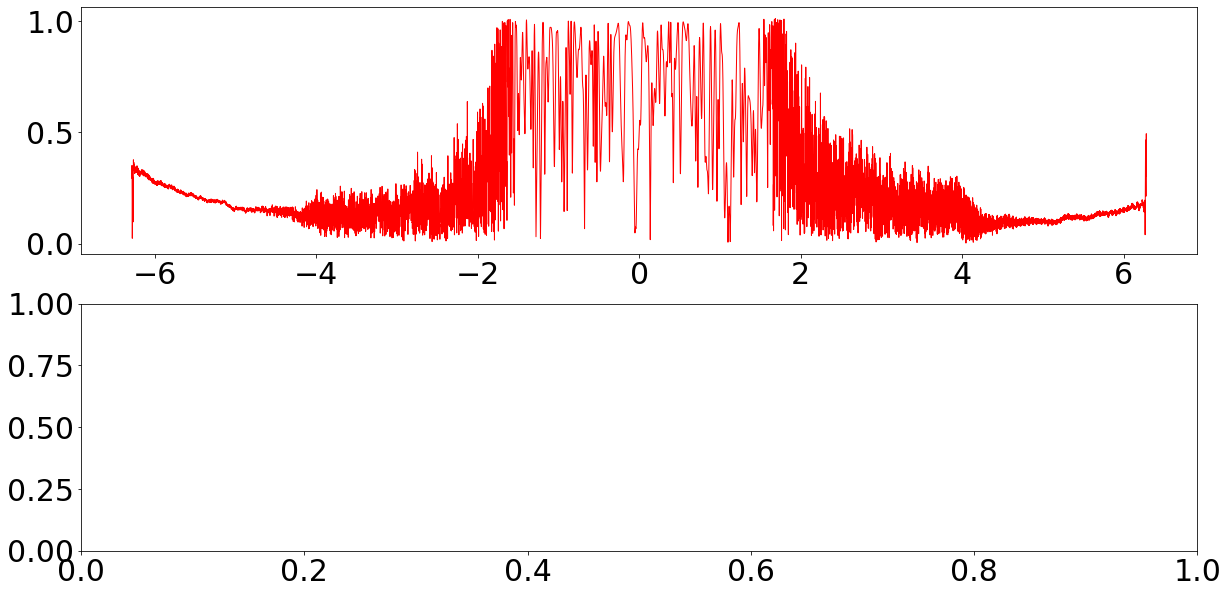

In [194]:
matplotlib.rcParams.update({'font.size': 30})
color = ['red', 'blue', 'green', 'xkcd:light purple', 'xkcd:cyan', 'xkcd:lime green']
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].plot(xi, np.absolute(b), color[0], linewidth=1)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


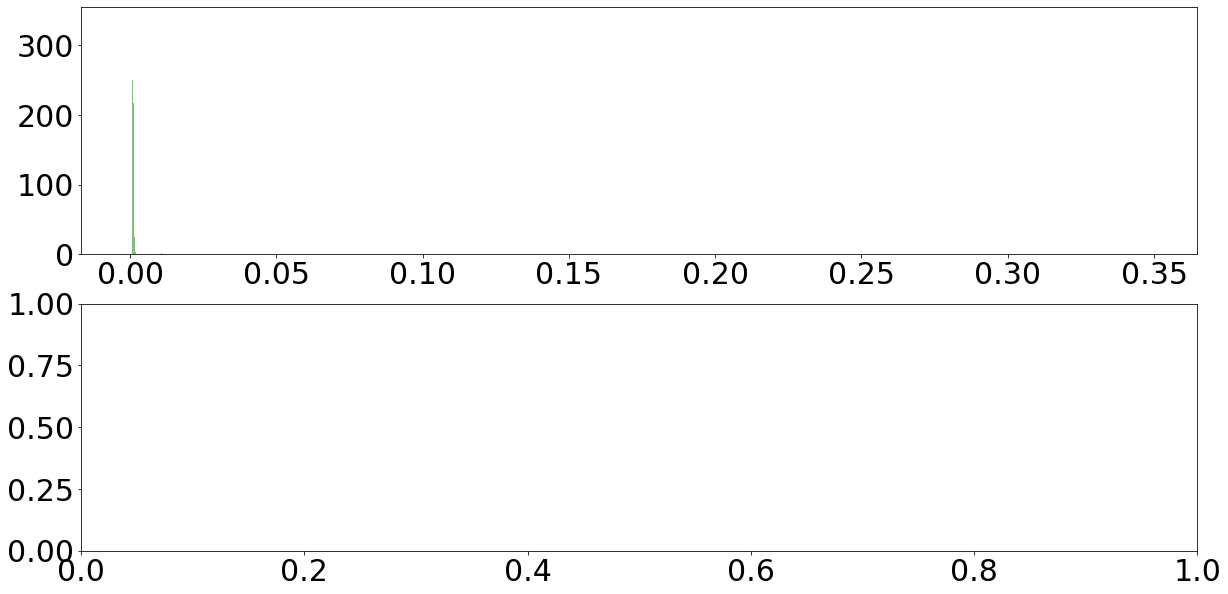

In [290]:
# calculate mean and standard deviation
mean = np.mean(evms)
median = np.median(evms)
std = np.std(evms)

fig, axs = plt.subplots(2, 1, figsize=(20, 10))
# plot histogram
axs[0].hist(evms, bins=2000, alpha=0.5, color='g')  # you can adjust the number of bins as per your requirements

# add a vertical line at the mean
axs[0].axvline(mean, color='b', linestyle='dashed', linewidth=2)
axs[0].text(mean*1.05, plt.ylim()[1]*0.9, 'Mean: {:.2f}'.format(mean), fontsize=12, color='b')

axs[0].axvline(median, color='b', linestyle='dashed', linewidth=2)
axs[0].text(median*1.05, plt.ylim()[1]*0.9, 'Median: {:.2f}'.format(median), fontsize=12, color='b')

# add vertical lines at 2.5 standard deviations from the mean
axs[0].axvline(mean + 2.5*std, color='r', linestyle='dashed', linewidth=2)
axs[0].text((mean + 2.5*std)*1.05, plt.ylim()[1]*0.8, '+2.5 STD: {:.2f}'.format(mean + 2.5*std), fontsize=12, color='r')

axs[0].set_xlim(0, 0.05)

# show the plot
plt.show()

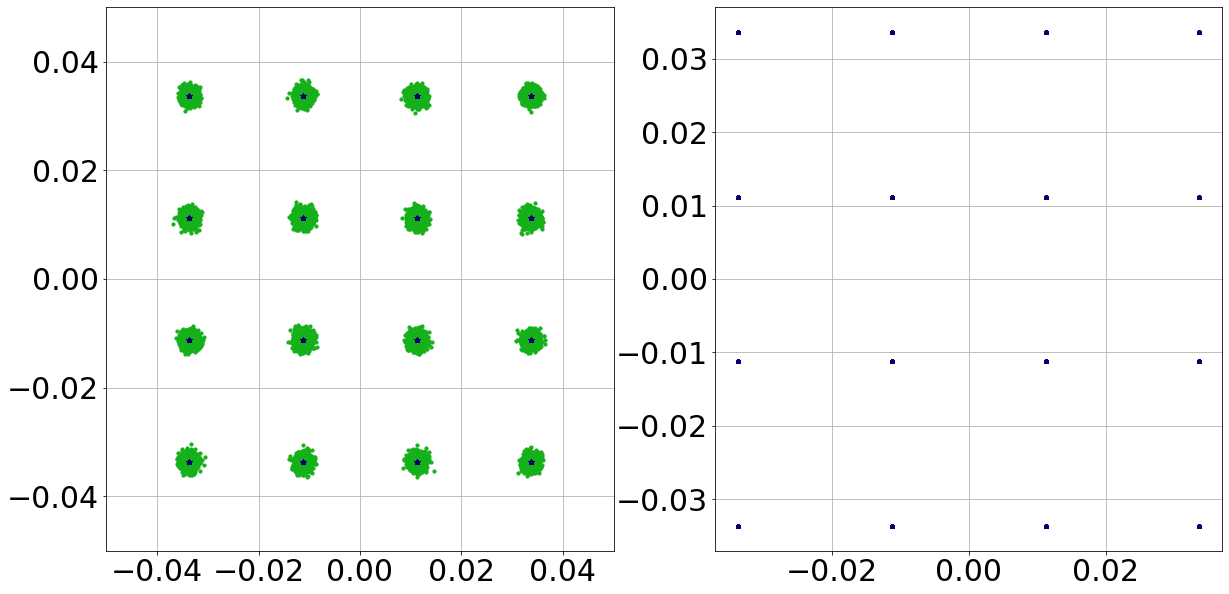

In [318]:
pk = 101
plot_range = range(pk * n_symb_proc, (pk + 1) * n_symb_proc)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
# axs[0].scatter(points_nft.real, points_nft.imag, s=10, c='xkcd:green', marker='o')
axs[0].scatter(points_nft_good.real, points_nft_good.imag, s=10, c='xkcd:green', marker='o')
# axs[0].scatter(points_nft[plot_range].real, points_nft[plot_range].imag, s=20, c='xkcd:red', marker='o')
# axs[0].scatter(points_nft_slice[outlier_indices].real, points_nft_slice[outlier_indices].imag, s=20, c='xkcd:red', marker='o')
axs[0].scatter(points.real, points.imag, s=20, c='xkcd:deep blue', marker='*')
axs[0].grid(True)
axs[0].set_xlim([-0.05, 0.05])
axs[0].set_ylim([-0.05, 0.05])

axs[1].scatter(points.real, points.imag, s=15, c='xkcd:deep blue', marker='*')
axs[1].grid(True)